# Multi-Level Monte Carlo (MLMC)

Euler-Maruyama on GBM. Giles (2008) convergence analysis.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cppfm
import time

plt.style.use('seaborn-v0_8-whitegrid')

# GBM params
S0 = 100.0
K = 100.0
r = 0.05
sigma = 0.2
T = 1.0

bs_price = cppfm.bs_call_price(S0, K, r, sigma, T)
print(f'BS reference price: {bs_price:.6f}')

BS reference price: 10.450584


In [13]:
def euler_gbm(S0, r, sigma, T, M, N, rng):
    """Euler-Maruyama GBM. Returns terminal S values (N paths, M steps)."""
    dt = T / M
    S = np.full(N, S0)
    sqrt_dt = np.sqrt(dt)
    for _ in range(M):
        Z = rng.standard_normal(N)
        S = S + r * S * dt + sigma * S * sqrt_dt * Z
        S = np.maximum(S, 0.0)  # absorb at zero
    return S

In [ ]:
def standard_mc(S0, K, r, sigma, T, M, N, seed=42):
    """Baseline MC pricer. Returns (price, stderr)."""
    rng = np.random.default_rng(seed)
    S_T = euler_gbm(S0, r, sigma, T, M, N, rng)
    payoffs = np.exp(-r * T) * np.maximum(S_T - K, 0.0)
    return payoffs.mean(), payoffs.std() / np.sqrt(N)

# sanity check
price_mc, se_mc = standard_mc(S0, K, r, sigma, T, M=256, N=200000)
print(f'Standard MC (M=256, N=200k): {price_mc:.4f} ± {se_mc:.4f}')
print(f'BS price:                    {bs_price:.4f}')
print(f'Error:                       {abs(price_mc - bs_price):.4f}')

Standard MC (M=256, N=200k): 10.4920 ± 0.0330
BS price:                     10.4506
Error:                        0.0414


In [15]:
def mlmc_level_sample(l, N, S0, K, r, sigma, T, M0, rng):
    """Coupled coarse/fine paths for level l. Returns (P_fine, P_coarse) arrays.
    
    l=0: just fine paths (M0 steps), P_coarse=0.
    l>=1: fine has M0*2^l steps, coarse has M0*2^(l-1).
    Coupling: two fine dW increments summed to get one coarse dW.
    """
    df = np.exp(-r * T)
    M_fine = M0 * (2 ** l)
    dt_fine = T / M_fine
    sqrt_dt_fine = np.sqrt(dt_fine)

    S_fine = np.full(N, S0)

    if l == 0:
        # level 0: just fine
        for _ in range(M_fine):
            Z = rng.standard_normal(N)
            S_fine = S_fine + r * S_fine * dt_fine + sigma * S_fine * sqrt_dt_fine * Z
            S_fine = np.maximum(S_fine, 0.0)
        P_fine = df * np.maximum(S_fine - K, 0.0)
        return P_fine, np.zeros(N)

    # l >= 1: coupled paths
    M_coarse = M0 * (2 ** (l - 1))
    dt_coarse = T / M_coarse
    S_coarse = np.full(N, S0)

    for j in range(M_coarse):
        # two fine steps per one coarse step
        Z1 = rng.standard_normal(N)
        S_fine = S_fine + r * S_fine * dt_fine + sigma * S_fine * sqrt_dt_fine * Z1
        S_fine = np.maximum(S_fine, 0.0)

        Z2 = rng.standard_normal(N)
        S_fine = S_fine + r * S_fine * dt_fine + sigma * S_fine * sqrt_dt_fine * Z2
        S_fine = np.maximum(S_fine, 0.0)

        # coarse step uses combined Brownian increment
        dW_coarse = sqrt_dt_fine * (Z1 + Z2)  # Var = 2*dt_fine = dt_coarse
        S_coarse = S_coarse + r * S_coarse * dt_coarse + sigma * S_coarse * dW_coarse
        S_coarse = np.maximum(S_coarse, 0.0)

    P_fine = df * np.maximum(S_fine - K, 0.0)
    P_coarse = df * np.maximum(S_coarse - K, 0.0)
    return P_fine, P_coarse

In [16]:
# level statistics + convergence rates
M0 = 2
L_max = 8
N_pilot = 50000
seed = 42
rng = np.random.default_rng(seed)

mean_l = np.zeros(L_max + 1)
var_l = np.zeros(L_max + 1)
cost_l = np.zeros(L_max + 1)

print(f'{"Level":>5} {"M_l":>6} {"E[Y_l]":>12} {"|E[Y_l]|":>12} {"Var[Y_l]":>12} {"Var*M_l":>12}')
print('-' * 65)

for l in range(L_max + 1):
    M_l = M0 * (2 ** l)
    P_fine, P_coarse = mlmc_level_sample(l, N_pilot, S0, K, r, sigma, T, M0, rng)
    Y_l = P_fine - P_coarse
    mean_l[l] = Y_l.mean()
    var_l[l] = Y_l.var()
    cost_l[l] = M_l
    print(f'{l:5d} {M_l:6d} {mean_l[l]:12.6f} {abs(mean_l[l]):12.6f} {var_l[l]:12.6f} {var_l[l]*M_l:12.4f}')

# telescoping check
tele_sum = mean_l.sum()
print(f'\nTelescoping sum: {tele_sum:.6f}')
print(f'BS price:        {bs_price:.6f}')
print(f'Difference:      {abs(tele_sum - bs_price):.6f}')

# fit alpha, beta from log-log slopes (skip first 2 levels for pre-asymptotic)
levels_fit = np.arange(2, L_max + 1)
log2_mean = np.log2(np.abs(mean_l[2:]))
log2_var = np.log2(var_l[2:])

alpha_fit = -np.polyfit(levels_fit, log2_mean, 1)[0]
beta_fit = -np.polyfit(levels_fit, log2_var, 1)[0]
print(f'\nalpha ~ {alpha_fit:.2f} (expected ~1.0)')
print(f'beta  ~ {beta_fit:.2f} (expected ~1.0)')

Level    M_l       E[Y_l]     |E[Y_l]|     Var[Y_l]      Var*M_l
-----------------------------------------------------------------
    0      2    10.324421    10.324421   187.406748     374.8135
    1      4     0.054652     0.054652     1.280257       5.1210
    2      8     0.015004     0.015004     0.657029       5.2562
    3     16     0.011619     0.011619     0.357650       5.7224
    4     32     0.001544     0.001544     0.180689       5.7821
    5     64    -0.001606     0.001606     0.091328       5.8450
    6    128     0.000083     0.000083     0.045219       5.7880
    7    256     0.000329     0.000329     0.022851       5.8497
    8    512     0.000692     0.000692     0.011767       6.0245

Telescoping sum: 10.406737
BS price:        10.450584
Difference:      0.043846

alpha ~ 0.99 (expected ~1.0)
beta  ~ 0.98 (expected ~1.0)


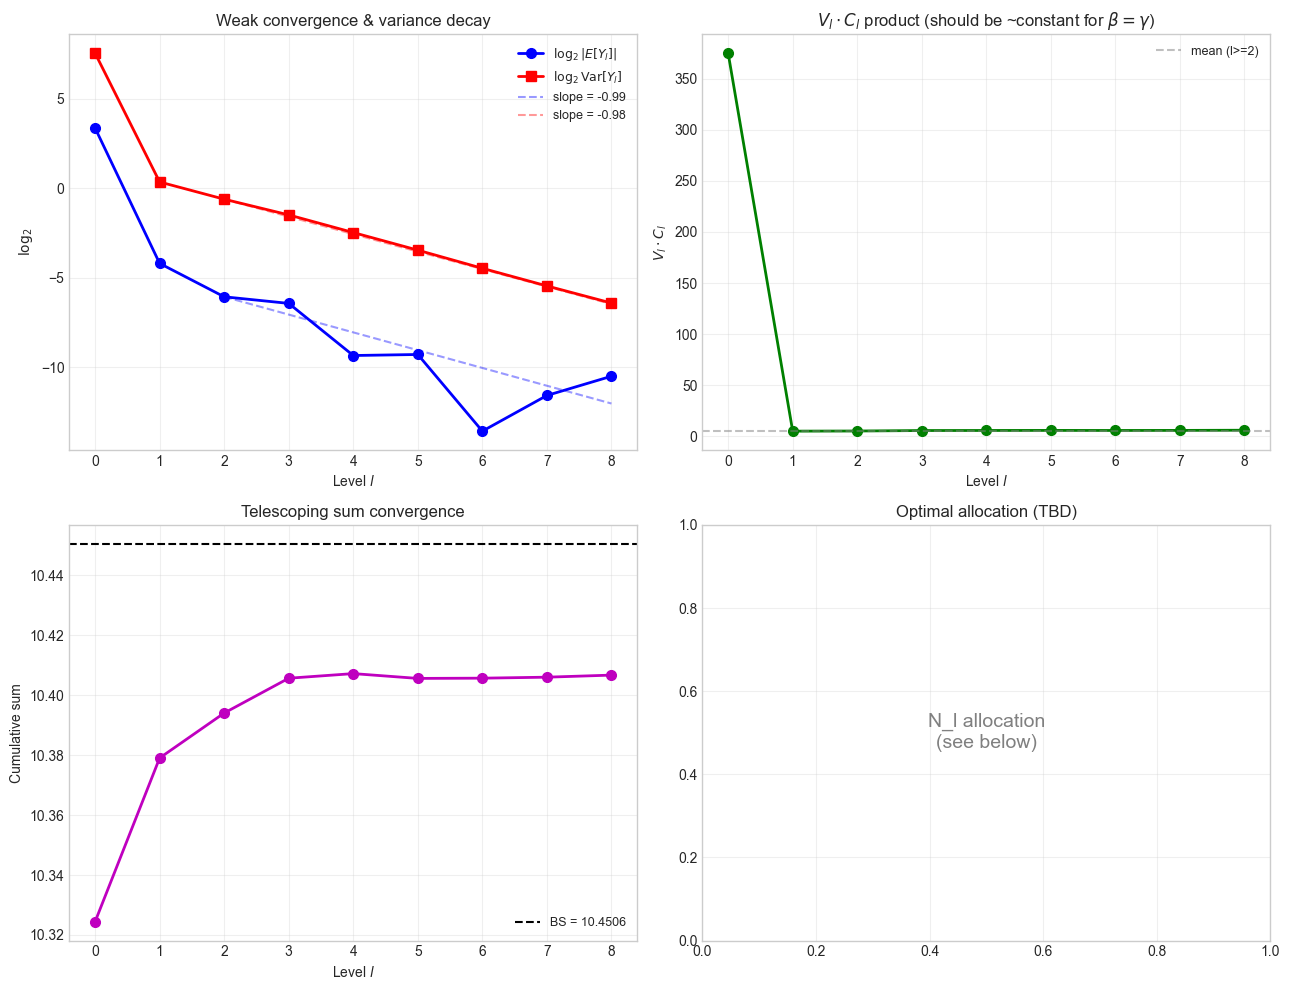

In [17]:
# Giles diagnostic plots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(13, 10))
levels = np.arange(L_max + 1)

# (1) log2|E[Y_l]| and log2 Var[Y_l] vs level
ax = axes[0, 0]
log2_abs_mean = np.log2(np.abs(mean_l))
log2_variance = np.log2(var_l)
ax.plot(levels, log2_abs_mean, 'bo-', linewidth=2, markersize=7, label=r'$\log_2 |E[Y_l]|$')
ax.plot(levels, log2_variance, 'rs-', linewidth=2, markersize=7, label=r'$\log_2 \mathrm{Var}[Y_l]$')
# reference slopes
x_ref = np.array([2, L_max])
ax.plot(x_ref, log2_abs_mean[2] - alpha_fit * (x_ref - 2), 'b--', alpha=0.4,
        label=f'slope = -{alpha_fit:.2f}')
ax.plot(x_ref, log2_variance[2] - beta_fit * (x_ref - 2), 'r--', alpha=0.4,
        label=f'slope = -{beta_fit:.2f}')
ax.set_xlabel('Level $l$')
ax.set_ylabel(r'$\log_2$')
ax.set_title('Weak convergence & variance decay')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (2) V_l * C_l vs level
ax = axes[0, 1]
vc_product = var_l * cost_l
ax.plot(levels, vc_product, 'go-', linewidth=2, markersize=7)
ax.axhline(np.mean(vc_product[2:]), color='gray', linestyle='--', alpha=0.5, label='mean (l>=2)')
ax.set_xlabel('Level $l$')
ax.set_ylabel('$V_l \cdot C_l$')
ax.set_title(r'$V_l \cdot C_l$ product (should be ~constant for $\beta=\gamma$)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (3) cumulative telescoping sum
ax = axes[1, 0]
cumsum = np.cumsum(mean_l)
ax.plot(levels, cumsum, 'mo-', linewidth=2, markersize=7)
ax.axhline(bs_price, color='k', linestyle='--', linewidth=1.5, label=f'BS = {bs_price:.4f}')
ax.set_xlabel('Level $l$')
ax.set_ylabel('Cumulative sum')
ax.set_title('Telescoping sum convergence')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (4) placeholder for N_l allocation — filled later
ax = axes[1, 1]
ax.text(0.5, 0.5, 'N_l allocation\n(see below)', transform=ax.transAxes,
        ha='center', va='center', fontsize=14, color='gray')
ax.set_title('Optimal allocation (TBD)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
def mlmc_estimator(eps, S0, K, r, sigma, T, M0=2, L_max=12, N_pilot=5000, seed=42):
    """Full MLMC estimator following Giles (2008) Thm 1.
    
    Returns dict with: price, L, N_l, V_l, cost, elapsed.
    Budget split: eps/sqrt(2) for bias, eps/sqrt(2) for variance.
    """
    t0 = time.time()
    rng = np.random.default_rng(seed)
    alpha_est = 1.0  # EM on GBM, known

    # start with a few levels, extend if bias too large
    L = min(4, L_max)

    # pilot run
    sums = np.zeros(L + 1)    # sum of Y_l
    sumsq = np.zeros(L + 1)   # sum of Y_l^2
    N_l = np.full(L + 1, N_pilot, dtype=int)

    for l in range(L + 1):
        P_f, P_c = mlmc_level_sample(l, N_pilot, S0, K, r, sigma, T, M0, rng)
        Y = P_f - P_c
        sums[l] = Y.sum()
        sumsq[l] = (Y**2).sum()

    # iteratively check bias and extend L if needed
    for _ in range(L_max - L):
        mean_est = sums / N_l
        var_est = sumsq / N_l - mean_est**2
        var_est = np.maximum(var_est, 1e-20)

        # bias check: |E[Y_L]| / (2^alpha - 1) < eps/sqrt(2)
        bias_bound = abs(mean_est[-1]) / (2**alpha_est - 1)
        if bias_bound < eps / np.sqrt(2):
            break

        # extend by one level
        L += 1
        if L > L_max:
            L = L_max
            break
        sums = np.append(sums, 0.0)
        sumsq = np.append(sumsq, 0.0)
        N_l = np.append(N_l, N_pilot)
        P_f, P_c = mlmc_level_sample(L, N_pilot, S0, K, r, sigma, T, M0, rng)
        Y = P_f - P_c
        sums[L] = Y.sum()
        sumsq[L] = (Y**2).sum()

    # compute variance estimates
    mean_est = sums / N_l
    var_est = sumsq / N_l - mean_est**2
    var_est = np.maximum(var_est, 1e-20)

    # optimal N_l: Giles Thm 1
    # N_l = ceil( eps^{-2} * sqrt(V_l/C_l) * sum_k sqrt(V_k * C_k) / 2 )
    # the /2 comes from splitting eps budget: variance target = (eps/sqrt(2))^2 = eps^2/2
    C_l = np.array([M0 * (2**l) for l in range(L + 1)], dtype=float)
    sqrt_vc = np.sqrt(var_est * C_l)
    sum_sqrt_vc = sqrt_vc.sum()
    N_opt = np.ceil(2.0 * eps**(-2) * np.sqrt(var_est / C_l) * sum_sqrt_vc).astype(int)
    N_opt = np.maximum(N_opt, 1)

    # draw additional samples where needed
    for l in range(L + 1):
        extra = N_opt[l] - N_l[l]
        if extra > 0:
            P_f, P_c = mlmc_level_sample(l, extra, S0, K, r, sigma, T, M0, rng)
            Y = P_f - P_c
            sums[l] += Y.sum()
            sumsq[l] += (Y**2).sum()
            N_l[l] = N_opt[l]

    price = (sums / N_l).sum()
    total_cost = (N_l * C_l).sum()
    elapsed = time.time() - t0

    return {
        'price': price,
        'L': L,
        'N_l': N_l.copy(),
        'V_l': var_est.copy(),
        'cost': total_cost,
        'elapsed': elapsed,
    }

eps=0.1: L=4, price=10.4414, cost=407538, time=0.01s
eps=0.02: L=5, price=10.4748, cost=4735716, time=0.05s


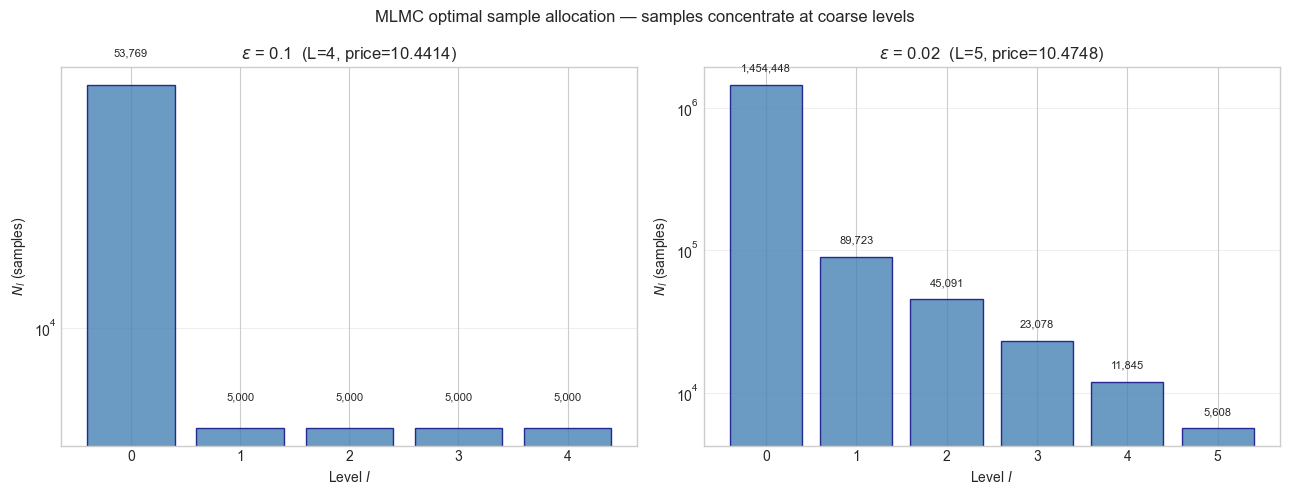

In [19]:
# N_l allocation bar chart for a couple eps values
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for i, eps in enumerate([0.1, 0.02]):
    res = mlmc_estimator(eps, S0, K, r, sigma, T)
    L = res['L']
    ax = axes[i]
    bars = ax.bar(range(L + 1), res['N_l'], color='steelblue', edgecolor='navy', alpha=0.8)
    ax.set_xlabel('Level $l$')
    ax.set_ylabel('$N_l$ (samples)')
    ax.set_title(f'$\\varepsilon$ = {eps}  (L={L}, price={res["price"]:.4f})')
    ax.set_yscale('log')
    ax.set_xticks(range(L + 1))
    ax.grid(True, alpha=0.3, axis='y')

    # annotate bars
    for bar, n in zip(bars, res['N_l']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.2,
                f'{n:,}', ha='center', va='bottom', fontsize=8)

    print(f'eps={eps}: L={L}, price={res["price"]:.4f}, cost={res["cost"]:.0f}, time={res["elapsed"]:.2f}s')

plt.suptitle('MLMC optimal sample allocation — samples concentrate at coarse levels', fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
# complexity sweep: MLMC vs standard MC
eps_values = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
mlmc_costs = []
smc_costs = []

print(f'{"eps":>6} {"MLMC cost":>12} {"SMC cost":>12} {"Speedup":>10} {"MLMC price":>12} {"L":>4}')
print('-' * 60)

for eps in eps_values:
    # MLMC
    res = mlmc_estimator(eps, S0, K, r, sigma, T, N_pilot=2000, seed=42)
    mlmc_costs.append(res['cost'])

    # standard MC: need bias < eps/sqrt(2) and stderr < eps/sqrt(2)
    # EM weak order 1: bias ~ C*h = C/M => M = ceil(C / (eps/sqrt(2)))
    # estimate C from pilot: bias at M=256 ~ |mc_price - bs_price|
    # simpler: use M = ceil(sigma^2 * S0^2 * T / (eps/sqrt(2))) ... 
    # just match the MLMC finest level for fair comparison
    M_smc = M0 * (2 ** res['L'])
    # variance of single payoff ~ var_l[0] (level 0 variance is full MC variance)
    # N = ceil(var / (eps/sqrt(2))^2)
    rng_tmp = np.random.default_rng(42)
    P_f, _ = mlmc_level_sample(0, 10000, S0, K, r, sigma, T, M_smc, rng_tmp)
    var_smc = P_f.var()
    N_smc = int(np.ceil(var_smc / (eps / np.sqrt(2))**2))
    smc_cost = N_smc * M_smc
    smc_costs.append(smc_cost)

    speedup = smc_cost / res['cost']
    print(f'{eps:6.3f} {res["cost"]:12.0f} {smc_cost:12.0f} {speedup:10.1f}x {res["price"]:12.4f} {res["L"]:4d}')

mlmc_costs = np.array(mlmc_costs)
smc_costs = np.array(smc_costs)

   eps    MLMC cost     SMC cost    Speedup   MLMC price    L
------------------------------------------------------------
 0.500       124382        55456        0.4x      10.1177    4
 0.200       147384       346432        2.4x      10.4390    4
 0.100       234382      1385632        5.9x      10.4540    4
 0.050       665072      5542528        8.3x      10.4340    4
 0.020      4096686     34640640        8.5x      10.4673    4
 0.010     16386598    138562528        8.5x      10.4477    4


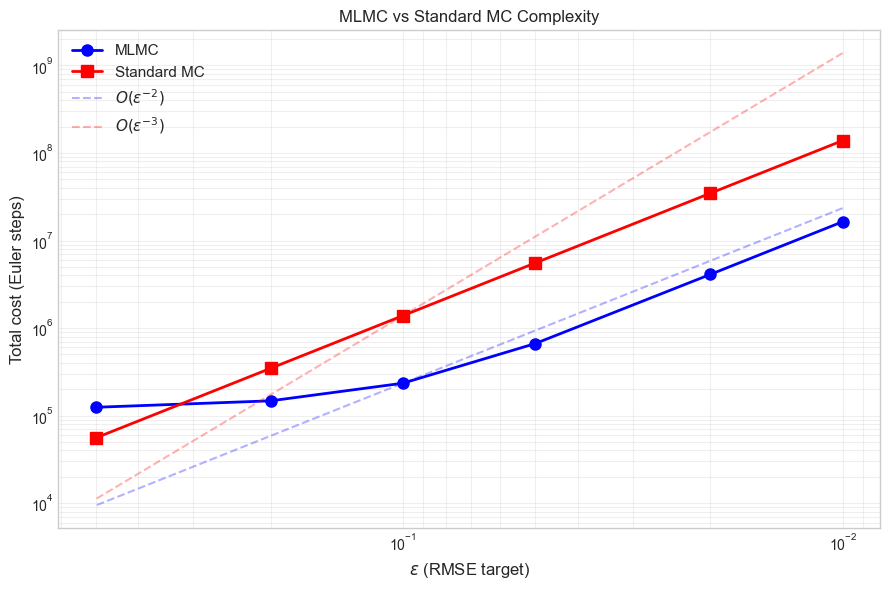


Speedup ratios:
  eps=0.500: 0.4x
  eps=0.200: 2.4x
  eps=0.100: 5.9x
  eps=0.050: 8.3x
  eps=0.020: 8.5x
  eps=0.010: 8.5x


In [21]:
# complexity log-log plot
fig, ax = plt.subplots(figsize=(9, 6))

eps_arr = np.array(eps_values)
ax.loglog(eps_arr, mlmc_costs, 'bo-', linewidth=2, markersize=8, label='MLMC')
ax.loglog(eps_arr, smc_costs, 'rs-', linewidth=2, markersize=8, label='Standard MC')

# reference slopes
eps_ref = np.array([eps_arr.min(), eps_arr.max()])
# O(eps^{-2} log^2 eps) for MLMC — approximate as eps^{-2} for the line
c_mlmc = mlmc_costs[2] * eps_arr[2]**2
ax.loglog(eps_ref, c_mlmc * eps_ref**(-2), 'b--', alpha=0.3, label=r'$O(\varepsilon^{-2})$')
# O(eps^{-3}) for standard MC
c_smc = smc_costs[2] * eps_arr[2]**3
ax.loglog(eps_ref, c_smc * eps_ref**(-3), 'r--', alpha=0.3, label=r'$O(\varepsilon^{-3})$')

ax.set_xlabel(r'$\varepsilon$ (RMSE target)', fontsize=12)
ax.set_ylabel('Total cost (Euler steps)', fontsize=12)
ax.set_title('MLMC vs Standard MC Complexity')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')
ax.invert_xaxis()
plt.tight_layout()
plt.show()

# print speedup summary
print('\nSpeedup ratios:')
for eps, mc, sm in zip(eps_values, mlmc_costs, smc_costs):
    print(f'  eps={eps:.3f}: {sm/mc:.1f}x')

RMSE validation at eps=0.05
Standard MC: M=32, N=175,506
Running 40 trials...

MLMC  RMSE: 0.0282  (target: 0.05)
SMC   RMSE: 0.0269  (target: 0.05)


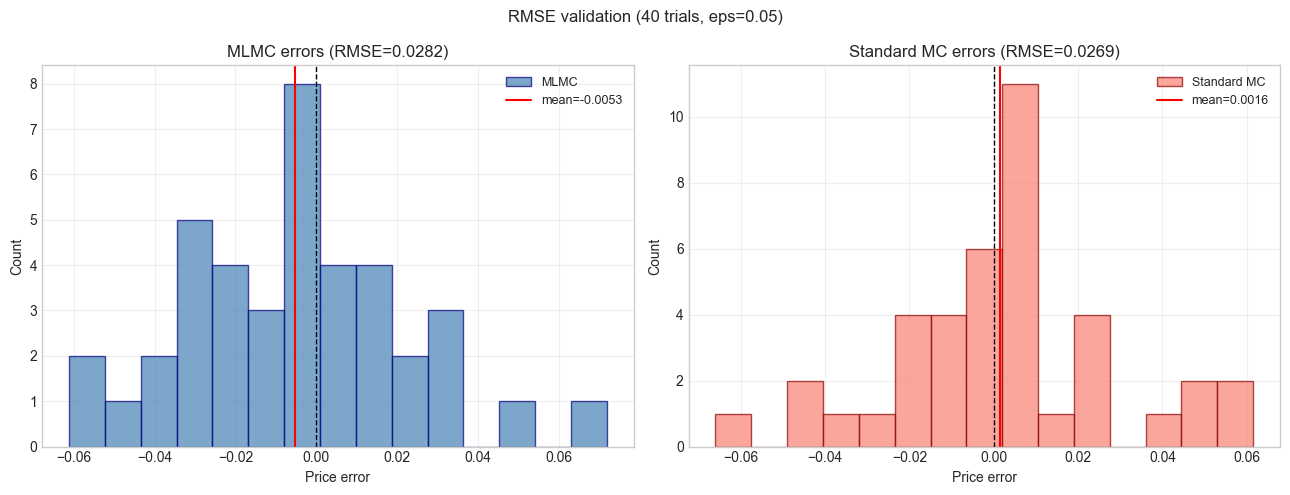

In [22]:
# RMSE validation: repeated independent trials
eps_test = 0.05
n_trials = 40

mlmc_errors = []
smc_errors = []

# for standard MC: match bias level, then set N for variance
# use same L as MLMC would pick
res_ref = mlmc_estimator(eps_test, S0, K, r, sigma, T, seed=0)
M_smc_val = M0 * (2 ** res_ref['L'])
rng_tmp = np.random.default_rng(0)
P_f_tmp, _ = mlmc_level_sample(0, 10000, S0, K, r, sigma, T, M_smc_val, rng_tmp)
var_smc_val = P_f_tmp.var()
N_smc_val = int(np.ceil(var_smc_val / (eps_test / np.sqrt(2))**2))

print(f'RMSE validation at eps={eps_test}')
print(f'Standard MC: M={M_smc_val}, N={N_smc_val:,}')
print(f'Running {n_trials} trials...\n')

for trial in range(n_trials):
    seed_t = 1000 + trial

    # MLMC
    res = mlmc_estimator(eps_test, S0, K, r, sigma, T, seed=seed_t)
    mlmc_errors.append(res['price'] - bs_price)

    # standard MC
    price_smc, _ = standard_mc(S0, K, r, sigma, T, M=M_smc_val, N=N_smc_val, seed=seed_t)
    smc_errors.append(price_smc - bs_price)

mlmc_errors = np.array(mlmc_errors)
smc_errors = np.array(smc_errors)

mlmc_rmse = np.sqrt(np.mean(mlmc_errors**2))
smc_rmse = np.sqrt(np.mean(smc_errors**2))
print(f'MLMC  RMSE: {mlmc_rmse:.4f}  (target: {eps_test})')
print(f'SMC   RMSE: {smc_rmse:.4f}  (target: {eps_test})')

# histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

ax1.hist(mlmc_errors, bins=15, alpha=0.7, color='steelblue', edgecolor='navy', label='MLMC')
ax1.axvline(0, color='k', linestyle='--', linewidth=1)
ax1.axvline(mlmc_errors.mean(), color='red', linestyle='-', linewidth=1.5, label=f'mean={mlmc_errors.mean():.4f}')
ax1.set_xlabel('Price error')
ax1.set_ylabel('Count')
ax1.set_title(f'MLMC errors (RMSE={mlmc_rmse:.4f})')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

ax2.hist(smc_errors, bins=15, alpha=0.7, color='salmon', edgecolor='darkred', label='Standard MC')
ax2.axvline(0, color='k', linestyle='--', linewidth=1)
ax2.axvline(smc_errors.mean(), color='red', linestyle='-', linewidth=1.5, label=f'mean={smc_errors.mean():.4f}')
ax2.set_xlabel('Price error')
ax2.set_ylabel('Count')
ax2.set_title(f'Standard MC errors (RMSE={smc_rmse:.4f})')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.suptitle(f'RMSE validation ({n_trials} trials, eps={eps_test})', fontsize=12)
plt.tight_layout()
plt.show()

## Summary

EM on GBM: alpha ~ 1 (weak order), beta ~ 1 (variance decay), gamma = 1 (cost per step).
MLMC complexity = O(eps^{-2} log^2 eps), standard MC = O(eps^{-3}). Giles (2008) Thm 1 confirmed.

Connects to C++ MLMC TODOs in `PathSimulator2D.h` and `VarianceReduction.h`.

## Asian Options — Path-Dependent MLMC

Arithmetic Asian call: payoff = max(A - K, 0) where A = (1/M) * sum S(t_i).
No closed form — reference price via fine MC. Geometric Asian (closed form) as sanity check.

In [23]:
from scipy.stats import norm

def geometric_asian_call(S0, K, r, sigma, T):
    """Continuous geometric Asian call — closed form via lognormal.
    log(G) ~ N(mu, v^2) under P*, price = exp(-rT) * E[max(G-K,0)]."""
    mu = np.log(S0) + (r - 0.5 * sigma**2) * T / 2
    v = sigma * np.sqrt(T / 3)
    d1 = (mu + v**2 - np.log(K)) / v
    d2 = d1 - v
    return np.exp(-r * T) * (np.exp(mu + 0.5 * v**2) * norm.cdf(d1) - K * norm.cdf(d2))

def mlmc_level_sample_asian(l, N, S0, K, r, sigma, T, M0, rng):
    """Coupled coarse/fine for arithmetic Asian call.
    Tracks running sum of S at each grid's monitoring points."""
    df = np.exp(-r * T)
    M_fine = M0 * (2 ** l)
    dt_fine = T / M_fine
    sqrt_dt_fine = np.sqrt(dt_fine)

    S_fine = np.full(N, S0)
    S_fine_sum = np.zeros(N)

    if l == 0:
        for _ in range(M_fine):
            Z = rng.standard_normal(N)
            S_fine = S_fine + r * S_fine * dt_fine + sigma * S_fine * sqrt_dt_fine * Z
            S_fine = np.maximum(S_fine, 0.0)
            S_fine_sum += S_fine
        A_fine = S_fine_sum / M_fine
        P_fine = df * np.maximum(A_fine - K, 0.0)
        return P_fine, np.zeros(N)

    # l >= 1: coupled paths
    M_coarse = M0 * (2 ** (l - 1))
    dt_coarse = T / M_coarse
    S_coarse = np.full(N, S0)
    S_coarse_sum = np.zeros(N)

    for j in range(M_coarse):
        Z1 = rng.standard_normal(N)
        S_fine = S_fine + r * S_fine * dt_fine + sigma * S_fine * sqrt_dt_fine * Z1
        S_fine = np.maximum(S_fine, 0.0)
        S_fine_sum += S_fine

        Z2 = rng.standard_normal(N)
        S_fine = S_fine + r * S_fine * dt_fine + sigma * S_fine * sqrt_dt_fine * Z2
        S_fine = np.maximum(S_fine, 0.0)
        S_fine_sum += S_fine

        dW_coarse = sqrt_dt_fine * (Z1 + Z2)
        S_coarse = S_coarse + r * S_coarse * dt_coarse + sigma * S_coarse * dW_coarse
        S_coarse = np.maximum(S_coarse, 0.0)
        S_coarse_sum += S_coarse

    A_fine = S_fine_sum / M_fine
    A_coarse = S_coarse_sum / M_coarse
    P_fine = df * np.maximum(A_fine - K, 0.0)
    P_coarse = df * np.maximum(A_coarse - K, 0.0)
    return P_fine, P_coarse

# reference prices
geom_price = geometric_asian_call(S0, K, r, sigma, T)
print(f'Geometric Asian (closed form): {geom_price:.6f}')

# arithmetic Asian reference via fine MC
M_ref = 2048
N_ref = 500000
rng_ref = np.random.default_rng(12345)
P_ref, _ = mlmc_level_sample_asian(0, N_ref, S0, K, r, sigma, T, M_ref, rng_ref)
asian_ref = P_ref.mean()
asian_se = P_ref.std() / np.sqrt(N_ref)
print(f'Arithmetic Asian (MC, M={M_ref}, N={N_ref//1000}k): {asian_ref:.6f} +/- {asian_se:.6f}')
print(f'European BS reference: {bs_price:.6f}')

Geometric Asian (closed form): 5.546819
Arithmetic Asian (MC, M=2048, N=500k): 5.743548 +/- 0.011260
European BS reference: 10.450584


In [ ]:
# Asian level statistics + convergence rates
L_max_asian = 8
N_pilot_asian = 50000
rng_asian = np.random.default_rng(42)

mean_l_asian = np.zeros(L_max_asian + 1)
var_l_asian = np.zeros(L_max_asian + 1)
cost_l_asian = np.zeros(L_max_asian + 1)

print(f'{"Level":>5} {"M_l":>6} {"E[Y_l]":>12} {"|E[Y_l]|":>12} {"Var[Y_l]":>12} {"Var*M_l":>12}')
print('-' * 65)

for l in range(L_max_asian + 1):
    M_l = M0 * (2 ** l)
    P_fine, P_coarse = mlmc_level_sample_asian(l, N_pilot_asian, S0, K, r, sigma, T, M0, rng_asian)
    Y_l = P_fine - P_coarse
    mean_l_asian[l] = Y_l.mean()
    var_l_asian[l] = Y_l.var()
    cost_l_asian[l] = M_l
    print(f'{l:5d} {M_l:6d} {mean_l_asian[l]:12.6f} {abs(mean_l_asian[l]):12.6f} {var_l_asian[l]:12.6f} {var_l_asian[l]*M_l:12.4f}')

tele_sum_asian = mean_l_asian.sum()
print(f'\nTelescoping sum: {tele_sum_asian:.6f}')
print(f'Asian ref price: {asian_ref:.6f}')
print(f'Difference:      {abs(tele_sum_asian - asian_ref):.6f}')

# fit rates (skip first 2 levels)
levels_fit_a = np.arange(2, L_max_asian + 1)
log2_mean_a = np.log2(np.abs(mean_l_asian[2:]))
log2_var_a = np.log2(var_l_asian[2:])

alpha_fit_asian = -np.polyfit(levels_fit_a, log2_mean_a, 1)[0]
beta_fit_asian = -np.polyfit(levels_fit_a, log2_var_a, 1)[0]
print(f'\nalpha ~ {alpha_fit_asian:.2f} (expected ~1.0)')
print(f'beta  ~ {beta_fit_asian:.2f} (expected >1, averaging smooths the payoff kink)')

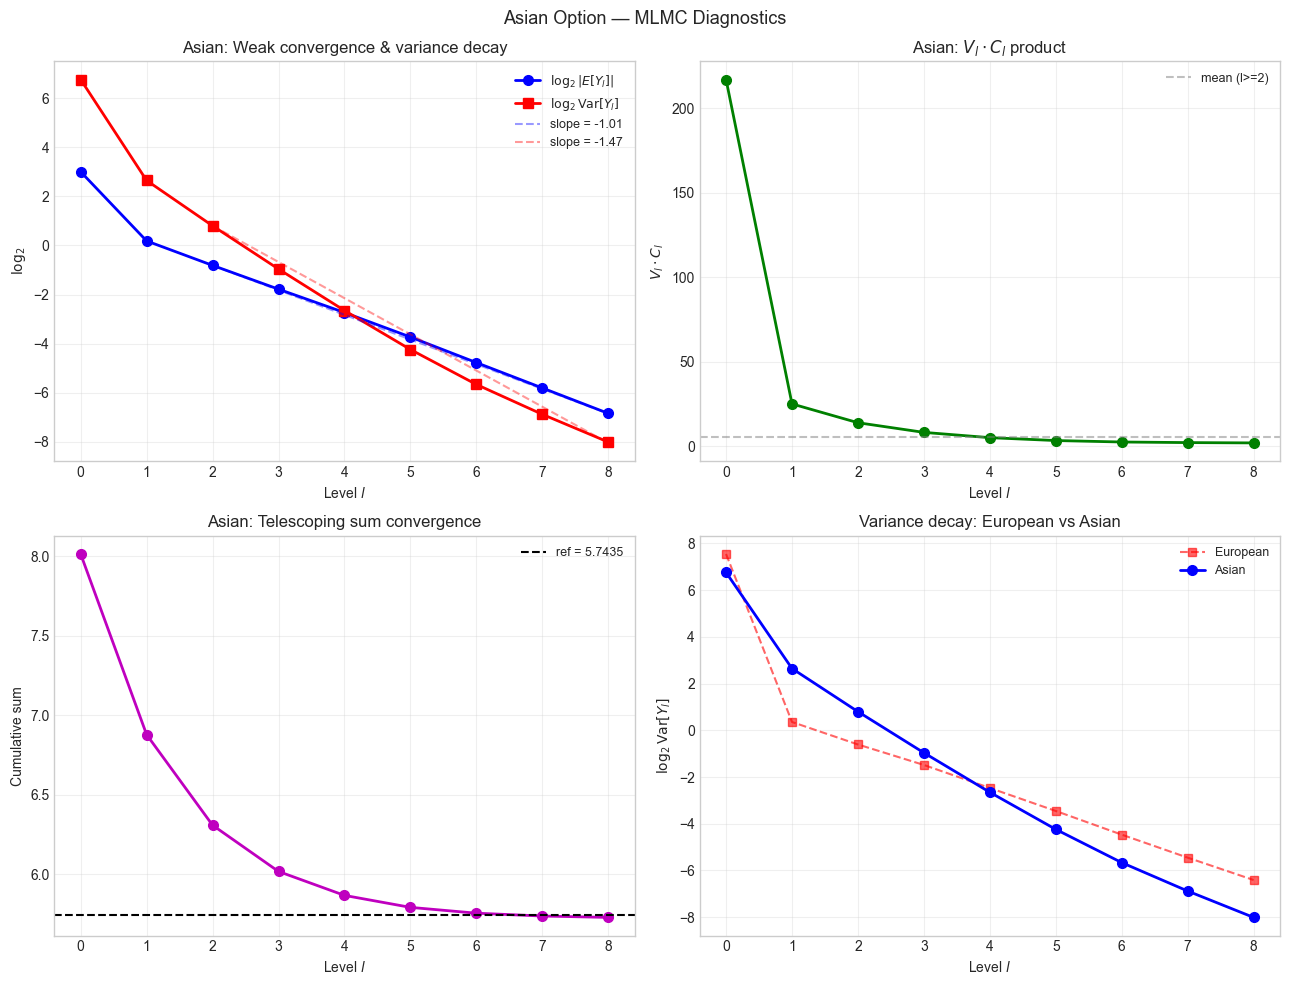

In [25]:
# Asian Giles diagnostic plots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(13, 10))
levels_a = np.arange(L_max_asian + 1)

# (1) convergence rates
ax = axes[0, 0]
log2_abs_mean_a = np.log2(np.abs(mean_l_asian))
log2_variance_a = np.log2(var_l_asian)
ax.plot(levels_a, log2_abs_mean_a, 'bo-', linewidth=2, markersize=7, label=r'$\log_2 |E[Y_l]|$')
ax.plot(levels_a, log2_variance_a, 'rs-', linewidth=2, markersize=7, label=r'$\log_2 \mathrm{Var}[Y_l]$')
x_ref = np.array([2, L_max_asian])
ax.plot(x_ref, log2_abs_mean_a[2] - alpha_fit_asian * (x_ref - 2), 'b--', alpha=0.4,
        label=f'slope = -{alpha_fit_asian:.2f}')
ax.plot(x_ref, log2_variance_a[2] - beta_fit_asian * (x_ref - 2), 'r--', alpha=0.4,
        label=f'slope = -{beta_fit_asian:.2f}')
ax.set_xlabel('Level $l$')
ax.set_ylabel(r'$\log_2$')
ax.set_title('Asian: Weak convergence & variance decay')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (2) V_l * C_l
ax = axes[0, 1]
vc_asian = var_l_asian * cost_l_asian
ax.plot(levels_a, vc_asian, 'go-', linewidth=2, markersize=7)
ax.axhline(np.mean(vc_asian[2:]), color='gray', linestyle='--', alpha=0.5, label='mean (l>=2)')
ax.set_xlabel('Level $l$')
ax.set_ylabel(r'$V_l \cdot C_l$')
ax.set_title(r'Asian: $V_l \cdot C_l$ product')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (3) telescoping sum
ax = axes[1, 0]
cumsum_asian = np.cumsum(mean_l_asian)
ax.plot(levels_a, cumsum_asian, 'mo-', linewidth=2, markersize=7)
ax.axhline(asian_ref, color='k', linestyle='--', linewidth=1.5, label=f'ref = {asian_ref:.4f}')
ax.set_xlabel('Level $l$')
ax.set_ylabel('Cumulative sum')
ax.set_title('Asian: Telescoping sum convergence')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (4) European vs Asian variance comparison
ax = axes[1, 1]
ax.plot(levels_a, np.log2(var_l), 'rs--', linewidth=1.5, markersize=6, alpha=0.6, label='European')
ax.plot(levels_a, np.log2(var_l_asian), 'bo-', linewidth=2, markersize=7, label='Asian')
ax.set_xlabel('Level $l$')
ax.set_ylabel(r'$\log_2 \mathrm{Var}[Y_l]$')
ax.set_title('Variance decay: European vs Asian')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.suptitle('Asian Option — MLMC Diagnostics', fontsize=13)
plt.tight_layout()
plt.show()

In [26]:
def mlmc_estimator_fn(eps, sampler, M0=2, L_max=12, N_pilot=5000, seed=42):
    """Generalized MLMC estimator. sampler(l, N, M0, rng) -> (P_fine, P_coarse)."""
    t0 = time.time()
    rng = np.random.default_rng(seed)
    alpha_est = 1.0

    L = min(4, L_max)
    sums = np.zeros(L + 1)
    sumsq = np.zeros(L + 1)
    N_l = np.full(L + 1, N_pilot, dtype=int)

    for l in range(L + 1):
        P_f, P_c = sampler(l, N_pilot, M0, rng)
        Y = P_f - P_c
        sums[l] = Y.sum()
        sumsq[l] = (Y**2).sum()

    for _ in range(L_max - L):
        mean_est = sums / N_l
        var_est = sumsq / N_l - mean_est**2
        var_est = np.maximum(var_est, 1e-20)
        bias_bound = abs(mean_est[-1]) / (2**alpha_est - 1)
        if bias_bound < eps / np.sqrt(2):
            break
        L += 1
        if L > L_max:
            L = L_max
            break
        sums = np.append(sums, 0.0)
        sumsq = np.append(sumsq, 0.0)
        N_l = np.append(N_l, N_pilot)
        P_f, P_c = sampler(L, N_pilot, M0, rng)
        Y = P_f - P_c
        sums[L] = Y.sum()
        sumsq[L] = (Y**2).sum()

    mean_est = sums / N_l
    var_est = sumsq / N_l - mean_est**2
    var_est = np.maximum(var_est, 1e-20)

    C_l = np.array([M0 * (2**l) for l in range(L + 1)], dtype=float)
    sqrt_vc = np.sqrt(var_est * C_l)
    N_opt = np.ceil(2.0 * eps**(-2) * np.sqrt(var_est / C_l) * sqrt_vc.sum()).astype(int)
    N_opt = np.maximum(N_opt, 1)

    for l in range(L + 1):
        extra = N_opt[l] - N_l[l]
        if extra > 0:
            P_f, P_c = sampler(l, extra, M0, rng)
            Y = P_f - P_c
            sums[l] += Y.sum()
            sumsq[l] += (Y**2).sum()
            N_l[l] = N_opt[l]

    price = (sums / N_l).sum()
    total_cost = (N_l * C_l).sum()
    return {
        'price': price, 'L': L, 'N_l': N_l.copy(),
        'V_l': var_est.copy(), 'cost': total_cost, 'elapsed': time.time() - t0,
    }

# sampler closures — capture GBM params from global scope
def asian_sampler(l, N, M0, rng):
    return mlmc_level_sample_asian(l, N, S0, K, r, sigma, T, M0, rng)

def european_sampler(l, N, M0, rng):
    return mlmc_level_sample(l, N, S0, K, r, sigma, T, M0, rng)

# quick sanity check
res_check = mlmc_estimator_fn(0.05, asian_sampler)
print(f'Asian MLMC (eps=0.05): {res_check["price"]:.4f}  (ref: {asian_ref:.4f})')

Asian MLMC (eps=0.05): 5.7411  (ref: 5.7435)


Asian eps=0.1: L=5, price=5.7501, cost=717000
Asian eps=0.02: L=8, price=5.7717, cost=9691488


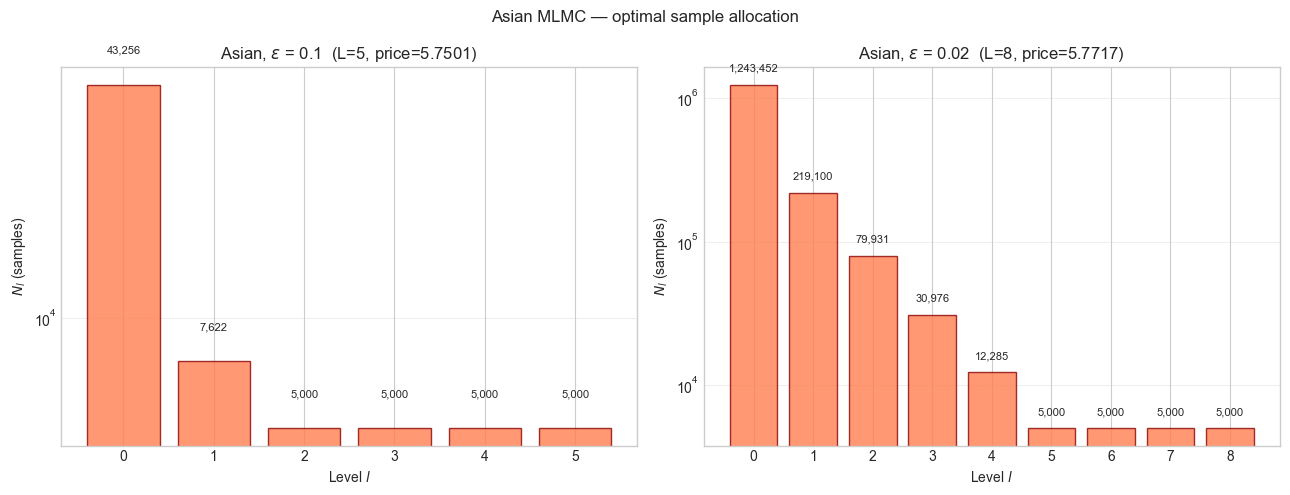

In [27]:
# Asian N_l allocation
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

for i, eps in enumerate([0.1, 0.02]):
    res = mlmc_estimator_fn(eps, asian_sampler)
    L = res['L']
    ax = axes[i]
    bars = ax.bar(range(L + 1), res['N_l'], color='coral', edgecolor='darkred', alpha=0.8)
    ax.set_xlabel('Level $l$')
    ax.set_ylabel('$N_l$ (samples)')
    ax.set_title(f'Asian, $\\varepsilon$ = {eps}  (L={L}, price={res["price"]:.4f})')
    ax.set_yscale('log')
    ax.set_xticks(range(L + 1))
    ax.grid(True, alpha=0.3, axis='y')

    for bar, n in zip(bars, res['N_l']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.2,
                f'{n:,}', ha='center', va='bottom', fontsize=8)

    print(f'Asian eps={eps}: L={L}, price={res["price"]:.4f}, cost={res["cost"]:.0f}')

plt.suptitle('Asian MLMC — optimal sample allocation', fontsize=12)
plt.tight_layout()
plt.show()

In [28]:
# complexity sweep: Asian vs European, MLMC vs SMC
eps_values_a = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]
mlmc_costs_asian = []
smc_costs_asian = []
mlmc_costs_euro = []
smc_costs_euro = []

print(f'{"eps":>6} {"MLMC Asian":>12} {"SMC Asian":>12} {"MLMC Euro":>12} {"SMC Euro":>12} {"Spdup A":>8} {"Spdup E":>8}')
print('-' * 80)

for eps in eps_values_a:
    # Asian MLMC
    res_a = mlmc_estimator_fn(eps, asian_sampler, N_pilot=2000, seed=42)
    mlmc_costs_asian.append(res_a['cost'])

    # Asian SMC: match finest level, estimate variance
    M_smc_a = M0 * (2 ** res_a['L'])
    rng_tmp = np.random.default_rng(42)
    P_f, _ = mlmc_level_sample_asian(0, 10000, S0, K, r, sigma, T, M_smc_a, rng_tmp)
    N_smc_a = int(np.ceil(P_f.var() / (eps / np.sqrt(2))**2))
    smc_costs_asian.append(N_smc_a * M_smc_a)

    # European MLMC
    res_e = mlmc_estimator_fn(eps, european_sampler, N_pilot=2000, seed=42)
    mlmc_costs_euro.append(res_e['cost'])

    # European SMC
    M_smc_e = M0 * (2 ** res_e['L'])
    rng_tmp = np.random.default_rng(42)
    P_f, _ = mlmc_level_sample(0, 10000, S0, K, r, sigma, T, M_smc_e, rng_tmp)
    N_smc_e = int(np.ceil(P_f.var() / (eps / np.sqrt(2))**2))
    smc_costs_euro.append(N_smc_e * M_smc_e)

    sa = smc_costs_asian[-1] / res_a['cost']
    se = smc_costs_euro[-1] / res_e['cost']
    print(f'{eps:6.3f} {res_a["cost"]:12.0f} {smc_costs_asian[-1]:12.0f} {res_e["cost"]:12.0f} {smc_costs_euro[-1]:12.0f} {sa:8.1f}x {se:8.1f}x')

mlmc_costs_asian = np.array(mlmc_costs_asian)
smc_costs_asian = np.array(smc_costs_asian)
mlmc_costs_euro = np.array(mlmc_costs_euro)
smc_costs_euro = np.array(smc_costs_euro)

   eps   MLMC Asian    SMC Asian    MLMC Euro     SMC Euro  Spdup A  Spdup E
--------------------------------------------------------------------------------
 0.500       124000        16864       124382        55456      0.1x      0.4x
 0.200       269836       210304       147384       346432      0.8x      2.4x
 0.100       628964      1664640       234382      1385632      2.6x      5.9x
 0.050      1657100     13251840       665072      5542528      8.0x      8.3x
 0.020      7079652    169171456      4096686     34640640     23.9x      8.5x
 0.010     27216070   1349196800     16386598    138562528     49.6x      8.5x


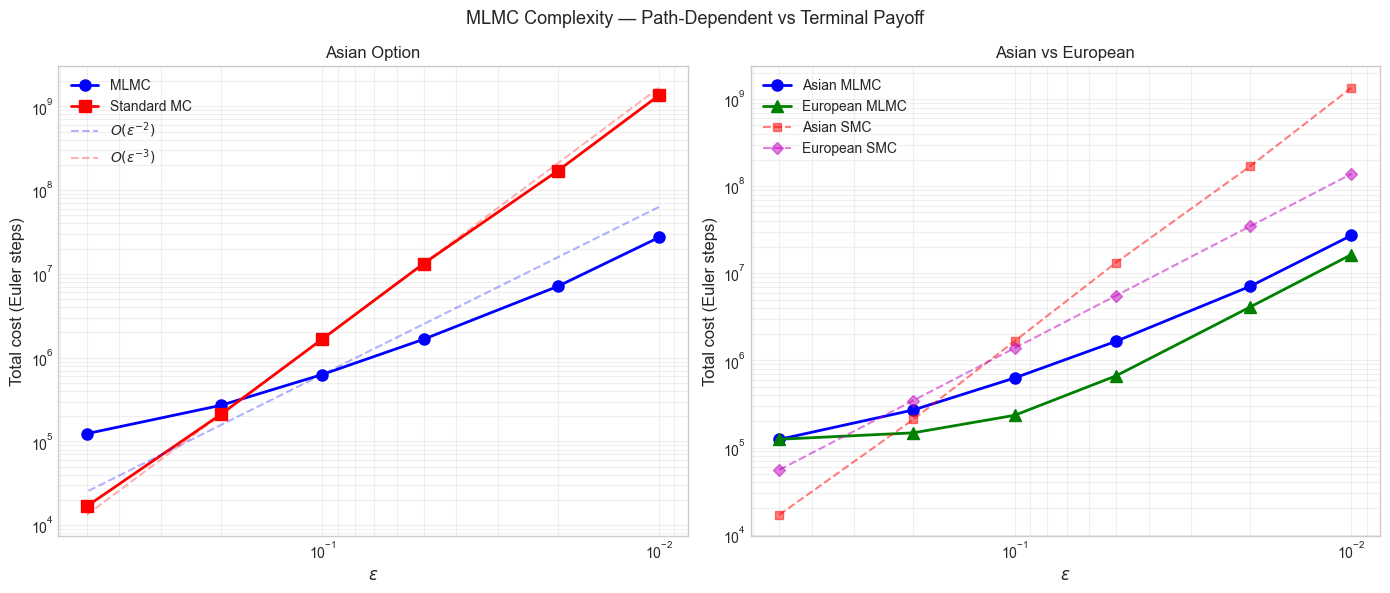


MLMC speedup over Standard MC:
   eps      Asian   European
 0.500        0.1x        0.4x
 0.200        0.8x        2.4x
 0.100        2.6x        5.9x
 0.050        8.0x        8.3x
 0.020       23.9x        8.5x
 0.010       49.6x        8.5x


In [29]:
# complexity log-log: Asian vs European, MLMC vs SMC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
eps_arr = np.array(eps_values_a)

# left: Asian MLMC vs SMC
ax1.loglog(eps_arr, mlmc_costs_asian, 'bo-', linewidth=2, markersize=8, label='MLMC')
ax1.loglog(eps_arr, smc_costs_asian, 'rs-', linewidth=2, markersize=8, label='Standard MC')
eps_ref = np.array([eps_arr.min(), eps_arr.max()])
c2 = mlmc_costs_asian[2] * eps_arr[2]**2
c3 = smc_costs_asian[2] * eps_arr[2]**3
ax1.loglog(eps_ref, c2 * eps_ref**(-2), 'b--', alpha=0.3, label=r'$O(\varepsilon^{-2})$')
ax1.loglog(eps_ref, c3 * eps_ref**(-3), 'r--', alpha=0.3, label=r'$O(\varepsilon^{-3})$')
ax1.set_xlabel(r'$\varepsilon$', fontsize=12)
ax1.set_ylabel('Total cost (Euler steps)', fontsize=12)
ax1.set_title('Asian Option')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, which='both')
ax1.invert_xaxis()

# right: MLMC comparison (Asian vs European)
ax2.loglog(eps_arr, mlmc_costs_asian, 'bo-', linewidth=2, markersize=8, label='Asian MLMC')
ax2.loglog(eps_arr, mlmc_costs_euro, 'g^-', linewidth=2, markersize=8, label='European MLMC')
ax2.loglog(eps_arr, smc_costs_asian, 'rs--', linewidth=1.5, markersize=6, alpha=0.5, label='Asian SMC')
ax2.loglog(eps_arr, smc_costs_euro, 'mD--', linewidth=1.5, markersize=6, alpha=0.5, label='European SMC')
ax2.set_xlabel(r'$\varepsilon$', fontsize=12)
ax2.set_ylabel('Total cost (Euler steps)', fontsize=12)
ax2.set_title('Asian vs European')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')
ax2.invert_xaxis()

plt.suptitle('MLMC Complexity — Path-Dependent vs Terminal Payoff', fontsize=13)
plt.tight_layout()
plt.show()

# speedup summary
print('\nMLMC speedup over Standard MC:')
print(f'{"eps":>6} {"Asian":>10} {"European":>10}')
for eps, ma, sa, me, se in zip(eps_values_a, mlmc_costs_asian, smc_costs_asian,
                                mlmc_costs_euro, smc_costs_euro):
    print(f'{eps:6.3f} {sa/ma:10.1f}x {se/me:10.1f}x')

## Asian Summary

alpha ~ 1 (same weak order as European — EM on GBM). But beta ~ 1.47, faster than European's beta ~ 1.
Averaging smooths the payoff kink: max(A-K, 0) is softer than max(S_T-K, 0) because A is a sum of
correlated lognormals. MLMC benefits even more — O(eps^{-2}) with smaller constant than European.